# **PREPROCESSING**

In [ ]:
!curl https://raw.githubusercontent.com/AcipenserSturio/literary_genre_pdm/main/src/getting_texts_with_origs/fandoms.zip > fandoms.zip
!curl https://raw.githubusercontent.com/AcipenserSturio/literary_genre_pdm/main/src/getting_texts_with_origs/origs.zip > origs.zip
!mkdir                datasets/

!rm -rf               datasets/fandoms/
!mkdir                datasets/fandoms/
!unzip fandoms.zip -d datasets/fandoms/ &> /dev/null
!rm    fandoms.zip

!rm -rf               datasets/origs/
!mkdir                datasets/origs/
!unzip origs.zip   -d datasets/origs/   &> /dev/null
!rm    origs.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 56.8M  100 56.8M    0     0  46.7M      0  0:00:01  0:00:01 --:--:-- 46.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 53.9M  100 53.9M    0     0  44.4M      0  0:00:01  0:00:01 --:--:-- 44.4M


In [ ]:
# Provisional: only have one text from each category
!find -L datasets/fandoms ! -name '25628_3329264.txt' -type f -exec rm -f {} +
!find -L datasets/origs   ! -name '1625_3319548.txt'  -type f -exec rm -f {} +

In [ ]:
!python -m spacy download ru_core_news_lg &> /dev/null
!pip install pymorphy3 &> /dev/null

In [ ]:
import spacy
import os
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
from pathlib import Path
import re

from pymorphy3 import MorphAnalyzer

# nlp = spacy.load("ru_core_news_lg")
# nlp.max_length = 4000000

ORIGIN = Path("datasets")
DEST = ORIGIN / "lemmatized"

lemmatizer = MorphAnalyzer()

def lemmatize(filename, genre):
    dest_filename = DEST / genre / filename.name
    if dest_filename.exists():
        return
    with open(filename, 'r', encoding='utf-8') as f:
        text = f.read()
    tokens = re.findall("\w+", text)
    if len(tokens) > 100000:
        print(len(tokens))
    lemmas = [lemmatizer.parse(token)[0].normal_form for token in tokens]
    # lemmas = []
    # doc = nlp(text, disable = ['ner', 'parser'])
    # for token in doc:
    #     if token.lemma_.isalpha():
    #         lemmas.append(token.lemma_)
    if not os.path.exists(DEST / genre):
        os.makedirs(DEST / genre)
    with open(dest_filename, 'w', encoding='utf-8') as f:
        f.write(' '.join(lemmas))
    # return doc

GENRES = ["origs", "fandoms"]
for genre in GENRES:
    filenames = list((ORIGIN / genre).glob("*.txt"))
    print(f"total {genre}: {len(filenames)}")
    for file in tqdm(filenames):
        lemmatize(file, genre)

total origs: 1


100%|██████████| 1/1 [00:41<00:00, 41.08s/it]


total fandoms: 1


100%|██████████| 1/1 [00:23<00:00, 23.04s/it]


In [ ]:
# TODO: save progress
# !zip -r lemmatized.zip datasets/lemmatized/ &> /dev/null

# **LINGUISTIC GRAPH**

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

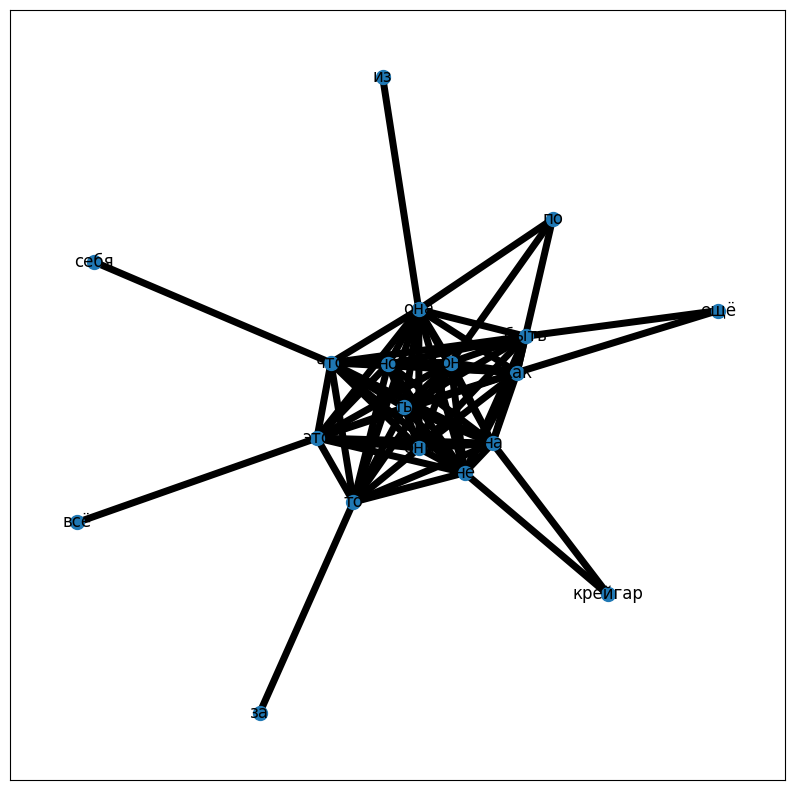

In [16]:
import os
import gensim
from gensim import utils
from tqdm.notebook import tqdm
from sklearn.neighbors import kneighbors_graph
from sklearn import metrics
from sklearn.preprocessing import minmax_scale, LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import k_means, SpectralClustering
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import pandas as pd

class Dataloader:
    def __iter__(self):
        for genre in tqdm(GENRES, leave=True):
            for file in tqdm(os.listdir('datasets/lemmatized/' + genre), leave=False):
                if ".txt" not in file:
                    continue
                with open('datasets/lemmatized/' + genre + '/' + file, 'r', encoding='utf-8') as f:
                    # use this when training
                    yield utils.simple_preprocess(f.read())
sentences = Dataloader()

word2vec = gensim.models.Word2Vec(sentences=sentences, vector_size=128, min_count=1)
word2vec.save('word2vec_model')

word2vec = gensim.models.Word2Vec.load('word2vec_model')

class Dataloader:
    def __iter__(self):
        for genre in tqdm(GENRES, leave=True):
            for file in tqdm(os.listdir('datasets/lemmatized/' + genre), leave=False):
                if ".txt" not in file:
                    continue
                with open('datasets/lemmatized/' + genre + '/' + file, 'r', encoding='utf-8') as f:
                    # use this when graphing
                    yield utils.simple_preprocess(f.read()), genre
sentences = Dataloader()

wv = word2vec.wv

graphs = []
text_len = []
true_labels = []

for num_sentence, (sentence, genre) in enumerate(sentences):
    #if num_sentence not in random_num:
    #    continue
    if not sentence:
        continue
    true_labels.append(genre)
    text_len.append(len(sentence))
    node_type = dict()
    edge_type = dict()
    node_weight = dict()
    nodes = []
    edges = []
    weights = []
    counter = Counter(sentence)
    top10 = counter.most_common(10)
    for word_i, count in top10:
        nodes.append(word_i)
        node_weight[word_i] = count / len(sentence)
        node_type[word_i] = 'core'
        words_in_text = np.array(list(set(sentence)))
        sim = wv.cosine_similarities(wv[word_i], wv[words_in_text])
        neigh_idx = np.argsort(sim)[-11:-1]
        for j in neigh_idx:
            word_j = words_in_text[j]
            if word_j not in nodes:
                nodes.append(word_j)
                node_weight[word_j] = counter[word_j] / len(sentence)
            edges.append([word_i, word_j, sim[j]])
    graph = nx.Graph()
    graph.add_nodes_from(nodes)
    graph.add_weighted_edges_from(edges)
    for node, degree in graph.degree:
        if degree == 1:
            node_type[node] = 'boundary'
    for node in set(graph.nodes).difference(node_type.keys()):
        node_type[node] = 'multiple'
    nx.set_node_attributes(graph, node_type, 'node_type')
    nx.set_node_attributes(graph, node_weight, 'node_weight')
    for (u, v) in graph.edges:
        types = set(nx.get_node_attributes(graph.subgraph([u, v]), 'node_type').values())
        if types == {'core'}:
            edge_type[(u, v)] = 'core'
        elif types == {'core', 'multiple'}:
            edge_type[(u, v)] = 'multiple'
        else:
            edge_type[(u, v)] = 'boundary'
    nx.set_edge_attributes(graph, edge_type, 'edge_type')
    graphs.append(graph)

plt.figure(figsize=(10, 10))
graph = nx.Graph(graphs[-1])
#cc_nodes = list(nx.connected_components(graph))[0]
#subgraph = graph.subgraph(cc_nodes)
weights = np.array(list(nx.get_edge_attributes(graph, 'weight').values()))
nx.draw_networkx(graph, node_size=100, width=(weights + 0.5)**4)

# **CHARACTER GRAPH**

In [ ]:
from os import listdir
from itertools import zip_longest, groupby
from pymystem3 import Mystem
from spacy.matcher import Matcher

nlp = spacy.load("ru_core_news_lg")
mystem = Mystem()

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [ ]:
!mkdir datasets/entities
!mkdir datasets/entities/origs
!mkdir datasets/entities/fandoms

!mkdir datasets/ner
!mkdir datasets/ner/origs
!mkdir datasets/ner/fandoms

!mkdir datasets/graph
!mkdir datasets/graph/origs
!mkdir datasets/graph/fandoms

!mkdir datasets/plots
!mkdir datasets/plots/origs
!mkdir datasets/plots/fandoms

In [ ]:
def extract_entities(
        in_dir="fanfics/",
        out_dir="entities/",
    ):
    for index, filename in enumerate(listdir(in_dir)):
        print(index, "extracting entities:", filename)

        if filename in listdir(out_dir):
            continue

        # Read fanfic, extract named entities
        with open(in_dir + filename, encoding='utf8') as f:
            text = f.read()
            named_entities = sorted(set(named_entity_recognition(text)), key=len, reverse=True)

        # Save entities
        with open(out_dir + filename, "w", encoding="utf-8") as f:
            f.write("\n".join(named_entities))

def named_entity_recognition(a):
    doc = nlp(a)
    named_entities = []

    for ent in doc.ents:
        if ent.label_ == "PER":
            # named_entities.append(ent.lemma_.replace('\n', " "))
            named_entities.append(ent.text.replace('\n', " "))
    return named_entities


In [ ]:
def corpus_markup(
        text_dir="fanfics/",
        entity_dir="entities/",
        out_dir="ner/",
    ):
    for index, filename in enumerate(listdir(entity_dir)):
        print(index, "adding markup:", filename)

        if filename in listdir(out_dir):
            continue

        # Read fanfic
        with open(text_dir + filename, encoding='utf8') as f:
            text = f.read()

        # Load entities
        with open(entity_dir + filename, encoding="utf-8") as f:
            named_entities = f.read().split("\n")

        # Use entities to add markup
        with open(out_dir + filename, "w", encoding="utf-8") as f:
            for entity in named_entities:
                # Add brackets around every entity.
                # Ordered in the correct way to avoid doubling up or incomplete selections
                text = re.sub(f"(?<!<)({re.escape(entity)}[а-я]*)", r"<\g<1>>", text)
                # Remove bizarre empty marking. I don't know how and why it exists
                text = text.replace("<>", "")
            f.write(text)

    # with open("out.txt", "w", encoding="utf8") as file:
    #     for row in zip_longest(*named_entities, fillvalue=""):
    #         print(",".join(row) + "\n")
    #         file.write(",".join(row) + "\n")

In [ ]:
def knowledge_graph(
        text_dir="ner/",
        entity_dir="entities/",
        out_dir="graph/",
    ):
    for key, group in iter_fanfics(entity_dir, out_dir):
        #iterate all tags and remember nonerroneous
        multipage_tags = []
        for text in iter_chapters(text_dir, group):
            for sentence in iter_sentences(text):
                print(sentence)
                lemmatised = "".join(mystem.lemmatize(sentence))
                print(lemmatised)
                if tags := extract_tags(lemmatised):
                    if len("".join(tags))/len(sentence) > 0.5 and len(sentence.split()) > 10:
                        # These are sentences which erroneously received
                        # an unusually high number of tags. Skip them.
                        continue

                    # print(tags)
                    multipage_tags.extend(tags)
        counted_tags = Counter(multipage_tags)
        # for tag in sorted(counted_tags, key=counted_tags.get, reverse=True):
        #     count = counted_tags[tag]
        #     if count > 2:
        #         print(tag, count)
        counted_tags = {k: v for k, v in counted_tags.items() if v > 2}

        tag_groups = []
        # find all relevant triplet
        for text in iter_chapters(text_dir, group):
            for sentence in iter_sentences(text):
                lemmatised = "".join(mystem.lemmatize(sentence))
                tags = extract_tags(lemmatised)
                relevant_tags = set(counted_tags) & set(tags)
                if len(relevant_tags) > 1:
                    subj, obj, *_ = relevant_tags
                    if predicate := extract_predicate(sentence):
                        triplet = (subj, predicate, obj)
                        tag_groups.append(triplet)

        counted_tag_groups = Counter(tag_groups)
        with open(out_dir + key, "w", encoding="utf-8") as f:
            write = csv.writer(f, dialect='unix')
            for index, tag in enumerate(sorted(counted_tag_groups, key=counted_tag_groups.get, reverse=True)):
                # count = counted_tag_groups[tag]
                # if len(tag) != 2:
                #     # Sentence has multiple tags. Difficult to treat.
                #     continue
                # if index/len(counted_tag_groups) <= 0.1 and count >= 5:
                #     status = "взаимосвязан с"
                # elif count >= 2:
                #     status = "имеет отношение к"
                # else:
                #     status = "незначимо связан с"
                # write.writerow([tag[0], status, tag[1]])
                print(tag)
                write.writerow(tag)

def iter_fanfics(entity_dir, out_dir):
    for key, group in groupby(listdir(entity_dir), lambda x: x[:7]):
        group = list(group)
        # if len(group) > 1:
        #     print(key, len(list(group)))
        print("===============================")
        print(key)

        if key in listdir(out_dir):
            continue
        yield key, group


def iter_chapters(text_dir, group):
    for filename in group:
        # print("===============================")
        # print(key, filename)
        with open(text_dir + filename, "r", encoding="utf-8") as f:
            yield f.read()


def iter_sentences(text):
    text = re.split('\.|!|\?', text)
    for sentence in text:
        yield sentence


def extract_tags(lemmatised):
    return [tag for tag in re.findall("\<(.*?)\>", lemmatised) if tag]


def extract_predicate(sentence):
    #find predicate in sentence
    predicate = get_relation(sentence.replace("<", "").replace(">", ""))
    if not predicate:
        return
    predicate = mystem.lemmatize(predicate)[0]
    if len(predicate) < 3:
        return
    if predicate[-2:] not in ("ть", "ти", "чь", "ся"):
        return
    return predicate


In [ ]:
def get_relation(sent):

    doc = nlp(sent)

    # Объект класса Matcher
    matcher = Matcher(nlp.vocab)

    # Режим определения
    pattern = [{'DEP':'ROOT'},
               {'DEP':'prep','OP':"?"},
               {'DEP':'agent','OP':"?"},
               {'POS':'ADJ','OP':"?"}]

    matcher.add("matching_1", [pattern], on_match=None)

    matches = matcher(doc)
    if not matches:
        return
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]]

    return(span.text)

In [ ]:
import networkx as nx
import pandas as pd
import csv
import matplotlib.pyplot as plt
from os import listdir

def iter_csv_graphs(graph_dir="graph/", plot_dir="plots/"):
    for path in listdir(graph_dir):
        print(path)
        print("=========")
        if path in listdir(plot_dir):
            continue
        with open(graph_dir + path, encoding='UTF-8') as f:
            triplets = list(csv.reader(f))
            if not triplets:
                continue
            yield path, triplets

def get_edge_labels(triplets):
    return {(subj, obj): predicate for subj, predicate, obj in triplets}

def draw_graphs(graph_dir, plot_dir):
    for filename, triplets in iter_csv_graphs(graph_dir, plot_dir):
        subj, predicate, obj = zip(*triplets)

        kg_df = pd.DataFrame({'source':subj, 'target':obj, 'edge':predicate})

        print(kg_df)

        # Создание ориентированного графа из кадра данных
        G=nx.from_pandas_edgelist(kg_df, "source", "target",
                                edge_attr=True, create_using=nx.MultiDiGraph())

        plt.figure(figsize=(12,12))

        pos = nx.spring_layout(G)
        nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
        nx.draw_networkx_edge_labels(
            G, pos,
            edge_labels=get_edge_labels(triplets),
            font_color='indigo'
        )
        plt.show()
        break
        plt.savefig(f"{plot_dir}{filename}.png")


Streaming output truncated to the last 5000 lines.
 В своем вонючем лесу ты могла бы на всю жизнь остаться одна
 в свой вонючий лес ты мочь бы на весь жизнь оставаться один


      У меня были подруги, подумала <Биби>, много подруг, и все куда добрее, чем ты

      у я быть подруга, подумать <биби>, много подруга, и весь куда добрый, чем ты

 Но она ничего не сказала, только нахмурилась, стискивая зубы так, что челюсть заныла
 но она ничто не сказать, только нахмуриваться, стискивать зуб так, что челюсть заныть


      — Я сделаю тебя королевой <Эльзила> и <Апима>

      — я сделать ты королева <эльзить> и <апим>

 <Разве> это не стоит толики уважения и капли терпения
 <разве> это не стоить толика уважение и капля терпение


      — В очереди престолонаследия я так далека от трона, как твой замок от замка короля <Апима>

      — в очередь престолонаследие я так далекий от трон, как твой замок от замок король <апим>

 Не трудись
 не трудиться

 Женившись на мне, ты ничего не получишь, —

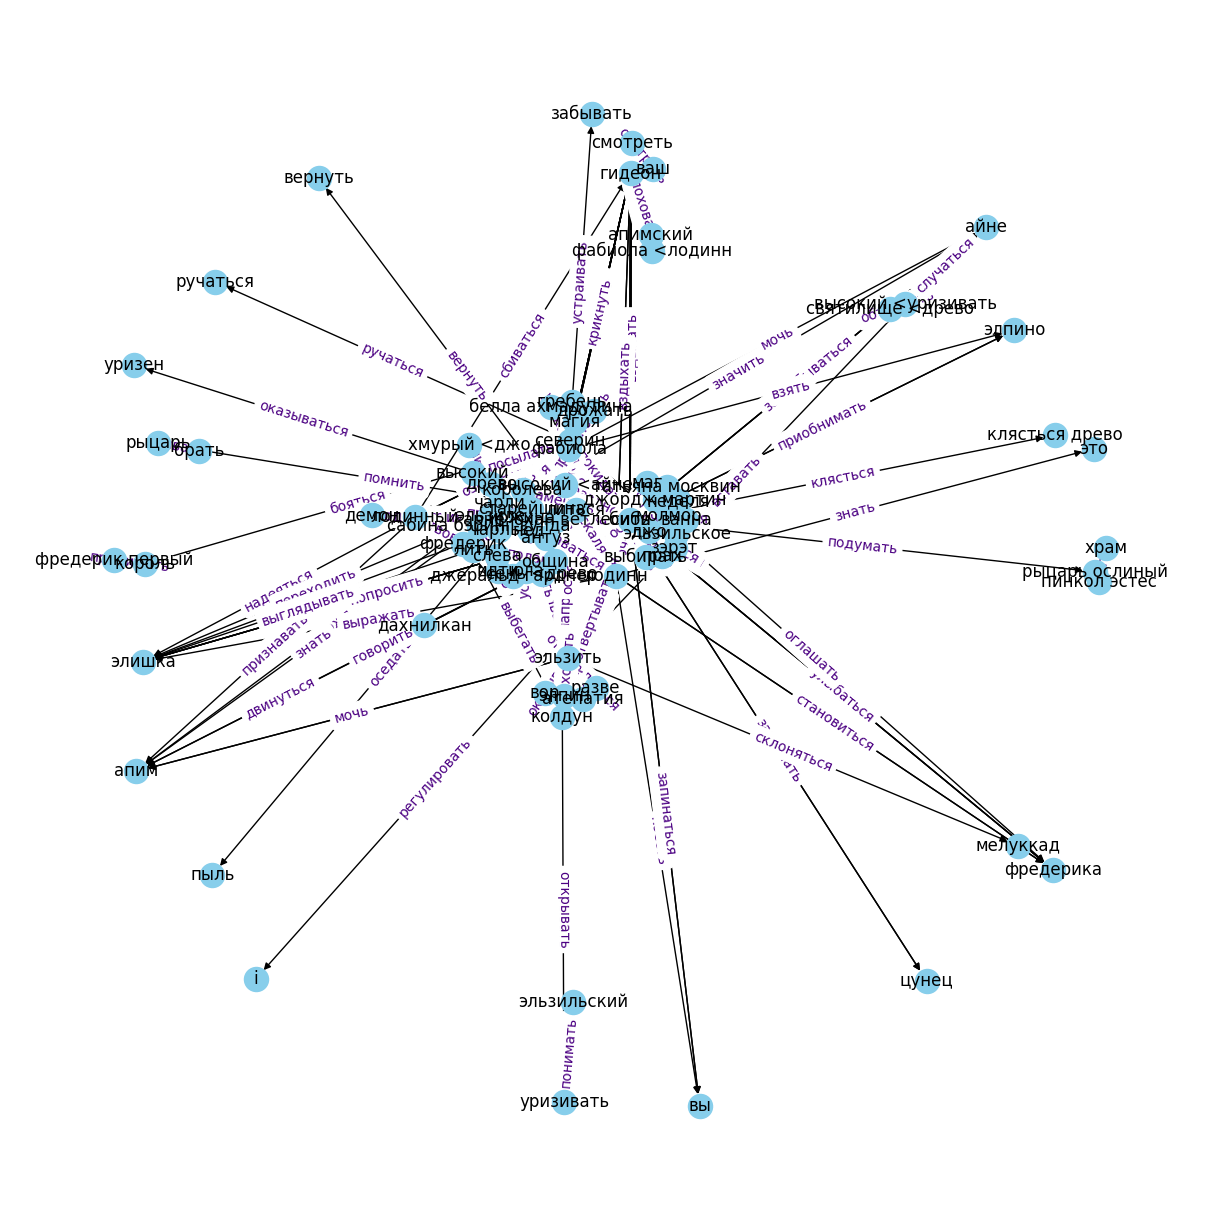

Streaming output truncated to the last 5000 lines.


- Я уже слышал, - улыбнулся он

- я уже слышать, - улыбаться он

 - Соседи уже судачат
 - сосед уже судачить

 Весь город поднялся на уши
 весь город подниматься на ухо

 Ищут карлика
 искать карлик

 Я знаю одного
 я знать один


- Как быстро, - усмехнулся я

- как быстро, - усмехаться я


- Город маленький, - рассеянно пожал плечами <Айбинн>

- город маленький, - рассеянно пожимать плечо <айбинна>

 - А тут такое событие… Сиди здесь
 - а тут такой событие… сидеть здесь

 Уйдешь следующей ночью
 уходить следующий ночь


- Спасибо, - я рухнул в угол

- спасибо, - я рухнуть в угол

 - Как мне тебя отблагодарить
 - как я ты отблагодарить

 Что тебе обещала <Кайра>
 что ты обещать <кайра>


- Работу в Адриланке, - пожал плечами он

- работа в адриланка, - пожимать плечо он


- Что-о

- что-о


- Она обещала забрать меня с собой в Адриланку, - вздохнул он

- она обещать забирать я с себя в адриланка, - вздыхать он

 - Тут совсем не ценят

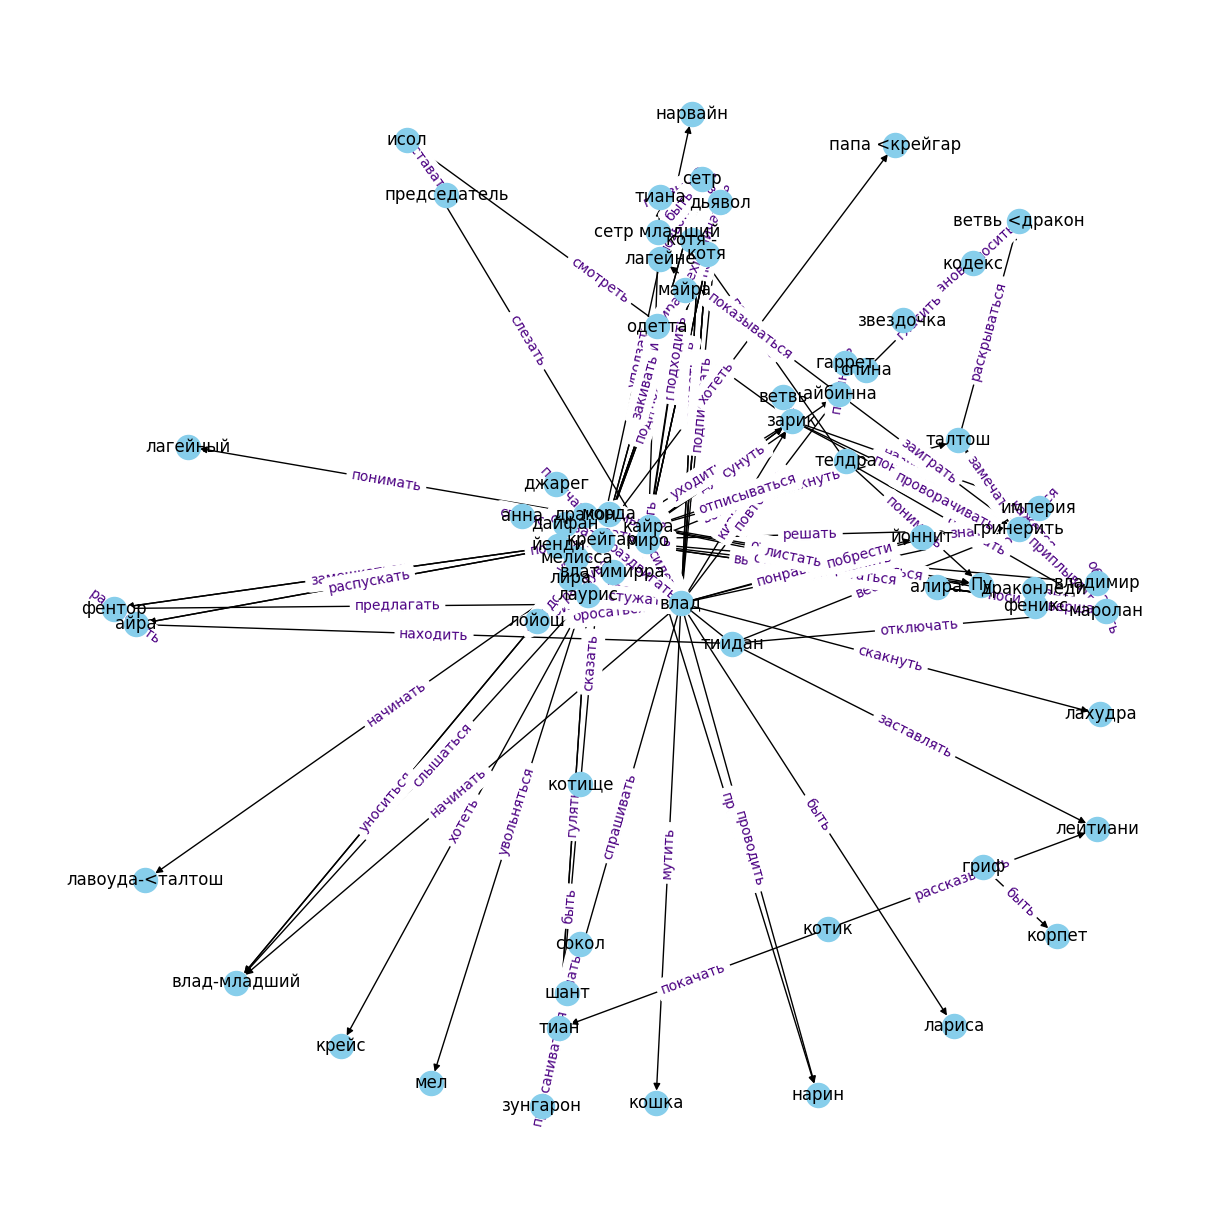

In [ ]:
for genre in GENRES:
    extract_entities(
        f"datasets/{genre}/",
        f"datasets/entities/{genre}/",
    )
    corpus_markup(
        f"datasets/{genre}/",
        f"datasets/entities/{genre}/",
        f"datasets/ner/{genre}/",
    )
    knowledge_graph(
        f"datasets/ner/{genre}/",
        f"datasets/entities/{genre}/",
        f"datasets/graph/{genre}/",
    )
    draw_graphs(
        f"datasets/graph/{genre}/",
        None,
    )